In [1]:
import os
import pandas as pd
import numpy as np
from dplython import (DplyFrame, X, diamonds, select, sift, sample_n, sample_frac, arrange, mutate, group_by, summarize)

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config IPCompleter.greedy=True

# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35, rc = {"figure.figsize": (10,6), "axes.facecolor": ".92"})

out_dir = '/Users/genie/dev/projects/github/got_survival_analysis/out'
os.chdir(out_dir)

/anaconda3/envs/dev2/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
data_path = '/Users/genie/dev/projects/github/got_survival_analysis/data/got_characters_s1_to_s7.csv'
character_df = pd.read_csv(data_path,quotechar='"',na_values='',encoding = "ISO-8859-1")

In [3]:
character_df['total_screen_time'] = character_df.apply(lambda x: sum([x['s'+str(i)+'_screenTime'] for i in range(1,8)]), axis=1)
character_df['num_of_episodes_appeared'] = character_df.apply(lambda x: sum([x['s'+str(i)+'_episodes'] for i in range(1,8)]), axis=1)
character_df['num_of_people_killed'] = character_df.apply(lambda x: sum([x['s'+str(i)+'_numKilled'] for i in range(1,8)]), axis=1)

character_df['spouse'] = character_df['spouse'].fillna('') 
character_df['is_married'] = character_df.apply(lambda x: (0 if x['spouse']=='' else 1), axis=1)

character_df['parents'] = character_df['parents'].fillna('')

character_df['siblings'] = character_df['siblings'].fillna('') 
character_df['have_siblings'] = character_df.apply(lambda x: (0 if x['siblings']=='' else 1), axis=1)                                                

character_df['parent_of'] = character_df['parent_of'].fillna('') 
character_df['have_children'] = character_df.apply(lambda x: (0 if x['parent_of']=='' else 1), axis=1)      

character_df['guardian_of'] = character_df['parent_of'].fillna('') 
character_df['is_guardian_for_any'] = character_df.apply(lambda x: (0 if x['guardian_of']=='' else 1), axis=1)      

character_df['guarded_by'] = character_df['guarded_by'].fillna('') 
character_df['is_guarded_by_any'] = character_df.apply(lambda x: (0 if x['guarded_by']=='' else 1), axis=1)      

character_df['served_by'] = character_df['served_by'].fillna('') 
character_df['is_served_by_any'] = character_df.apply(lambda x: (0 if x['served_by']=='' else 1), axis=1)      

character_df['serves'] = character_df['serves'].fillna('') 
character_df['serves_any'] = character_df.apply(lambda x: (0 if x['serves']=='' else 1), axis=1)      

character_df['allies'] = character_df['allies'].fillna('') 
character_df['have_allies'] = character_df.apply(lambda x: (0 if x['allies']=='' else 1), axis=1)      
                                                                     

In [4]:
dead_characters = list(character_df[character_df.is_dead==1]['character_name'].values)

def derive_if_have_any_dead_relatives(x):
    for p in x['spouse'].split(';'):
        if p in dead_characters:
            return(1)
    for p in x['parents'].split(';'):
        if p in dead_characters:
            return(1)
    for p in x['siblings'].split(';'):
        if p in dead_characters:
            return(1)
    for p in x['parent_of'].split(';'):
        if p in dead_characters:
            return(1)
    return(0)
    
def derive_if_have_any_dead_guardian(x):
    for p in x['guarded_by'].split(';'):
        if p in dead_characters:
            return(1)
    return(0)
        
def derive_if_have_any_guarded_dead(x):
    for p in x['guardian_of'].split(';'):
        if p in dead_characters:
            return(1)
    return(0)
        
def derive_if_have_any_dead_server(x):
    for p in x['served_by'].split(';'):
        if p in dead_characters:
            return(1)
    return(0)

def derive_if_have_any_served_dead(x):
    for p in x['serves'].split(';'):
        if p in dead_characters:
            return(1)
    return(0)
        
def derive_if_have_any_allies_dead(x):
    for p in x['allies'].split(';'):
        if p in dead_characters:
            return(1)
    return(0)

character_df['have_dead_relatives'] = character_df.apply(derive_if_have_any_dead_relatives, axis=1)
# character_df['have_dead_guardian'] = character_df.apply(derive_if_have_any_dead_guardian, axis=1)
# character_df['have_any_guarded_dead'] = character_df.apply(derive_if_have_any_guarded_dead, axis=1)
# character_df['have_dead_server'] = character_df.apply(derive_if_have_any_dead_server, axis=1)
# character_df['have_any_served_dead'] = character_df.apply(derive_if_have_any_served_dead, axis=1)
character_df['have_dead_allies'] = character_df.apply(derive_if_have_any_allies_dead, axis=1)


In [5]:
# remove unwanted variables
character_df = character_df.drop(['s'+str(i)+'_screenTime' for i in range(1,8)], axis=1)
character_df = character_df.drop(['s'+str(i)+'_shareOfScreenTime' for i in range(1,8)], axis=1)
character_df = character_df.drop(['s'+str(i)+'_episodes' for i in range(1,8)], axis=1)
character_df = character_df.drop(['s'+str(i)+'_numKilled' for i in range(1,8)], axis=1)
# character_df = character_df.drop(['s'+str(i)+'_numOfCharactersInteractedWith' for i in range(1,8)], axis=1)
character_df = character_df.drop(['spouse','parents','siblings','parent_of','manner_of_death',
                                  'killed_by','dead_in_season','guardian_of','guarded_by',
                                  'served_by','serves','allies'], axis=1)

In [6]:
character_df.head()

,character_name,gender,house,royal,kingsguard,s1_numOfCharactersInteractedWith,s1_bc,s1_ec,s2_numOfCharactersInteractedWith,s2_bc,...,is_married,have_siblings,have_children,is_guardian_for_any,is_guarded_by_any,is_served_by_any,serves_any,have_allies,have_dead_relatives,have_dead_allies
0,Addam Marbrand,male,NaN,0,0,4,0.0024,0.0003,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Aegon Targaryen,NaN,Targaryen,1,0,0,0.0000,0.0000,0,0.0,...,0,1,0,0,0,0,0,0,1,0
2,Aeron Greyjoy,male,Greyjoy,0,0,0,0.0000,-0.0000,0,0.0,...,0,1,0,0,0,0,0,0,1,0
3,Aerys II Targaryen,NaN,Targaryen,1,0,0,0.0000,-0.0000,0,0.0,...,1,1,1,1,0,1,0,0,1,0
4,Akho,male,NaN,0,0,0,0.0000,0.0000,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
character_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 41 columns):
character_name                      368 non-null object
gender                              337 non-null object
house                               86 non-null object
royal                               368 non-null int64
kingsguard                          368 non-null int64
s1_numOfCharactersInteractedWith    368 non-null int64
s1_bc                               368 non-null float64
s1_ec                               368 non-null float64
s2_numOfCharactersInteractedWith    368 non-null int64
s2_bc                               368 non-null float64
s2_ec                               368 non-null float64
s3_numOfCharactersInteractedWith    368 non-null int64
s3_bc                               368 non-null float64
s3_ec                               368 non-null float64
s4_numOfCharactersInteractedWith    368 non-null int64
s4_bc                               368 non-null float64

In [8]:
# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35, rc = {"figure.figsize": (10,6), "axes.facecolor": ".92"})

kmf = KaplanMeierFitter()
kmf.fit(durations = character_df.duration_in_episodes, event_observed = character_df.is_dead)

<lifelines.KaplanMeierFitter: fitted with 368 observations, 203 censored>

In [9]:
character_df[character_df.is_dead==0]['character_name'].count()

203

In [10]:
print(kmf.event_table)

          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0       368      368
1.0             5         5         0         0      368
2.0             3         3         0         0      363
5.0             2         2         0         0      360
6.0             4         4         0         0      358
7.0             1         1         0         0      354
8.0             5         5         0         0      353
9.0             1         1         0         0      348
10.0            4         4         0         0      347
11.0            1         1         0         0      343
12.0            1         1         0         0      342
13.0            2         2         0         0      341
15.0            2         2         0         0      339
16.0            4         4         0         0      337
17.0            7         7         0         0      333
19.0            2         2    

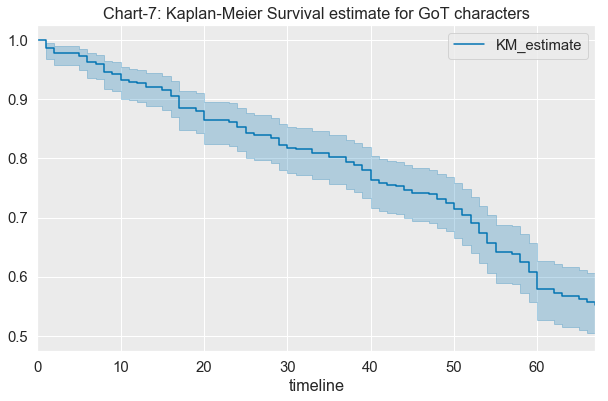

In [11]:
ax = kmf.plot_survival_function()
ax.set_title('Chart-7: Kaplan-Meier Survival estimate for GoT characters')
ax.get_figure().savefig("chart7.png")

In [12]:
kmf.predict(67)

0.5516304347826084

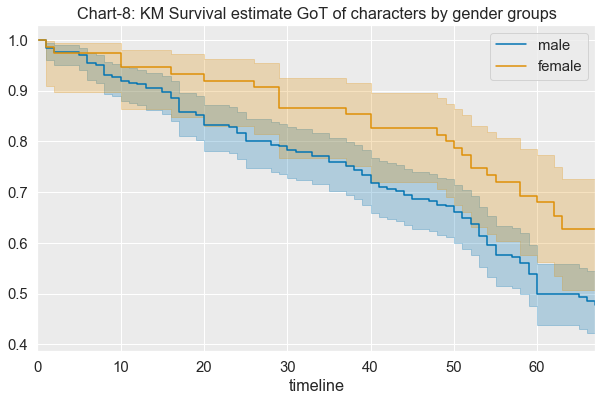

In [13]:
groups = character_df['gender']
g1 = (groups == 'male')
g2 = (groups == 'female')

kmf = KaplanMeierFitter()
kmf.fit(character_df['duration_in_episodes'][g1], character_df['is_dead'][g1], label='male')
ax = kmf.plot()

kmf.fit(character_df['duration_in_episodes'][g2], character_df['is_dead'][g2], label='female')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-8: KM Survival estimate GoT of characters by gender groups')
ax.get_figure().savefig("chart8.png")

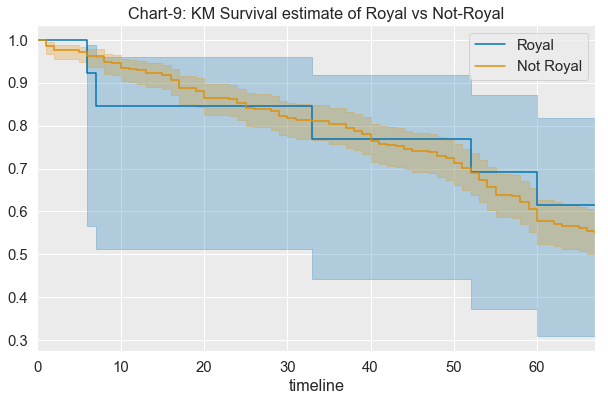

In [14]:
groups = character_df['royal']
g1 = (groups == 1)
g2 = (groups == 0)

kmf = KaplanMeierFitter()
kmf.fit(character_df['duration_in_episodes'][g1], character_df['is_dead'][g1], label='Royal')
ax = kmf.plot()

kmf.fit(character_df['duration_in_episodes'][g2], character_df['is_dead'][g2], label='Not Royal')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-9: KM Survival estimate of Royal vs Not-Royal')
ax.get_figure().savefig("chart9.png")

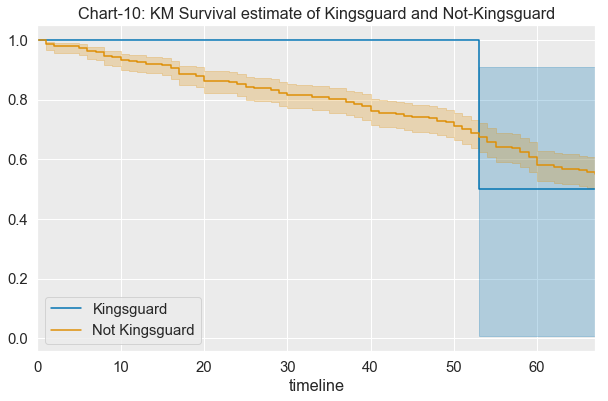

In [15]:
groups = character_df['kingsguard']
g1 = (groups == 1)
g2 = (groups == 0)

kmf = KaplanMeierFitter()
kmf.fit(character_df['duration_in_episodes'][g1], character_df['is_dead'][g1], label='Kingsguard')
ax = kmf.plot()

kmf.fit(character_df['duration_in_episodes'][g2], character_df['is_dead'][g2], label='Not Kingsguard')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-10: KM Survival estimate of Kingsguard and Not-Kingsguard')
ax.get_figure().savefig("chart10.png")

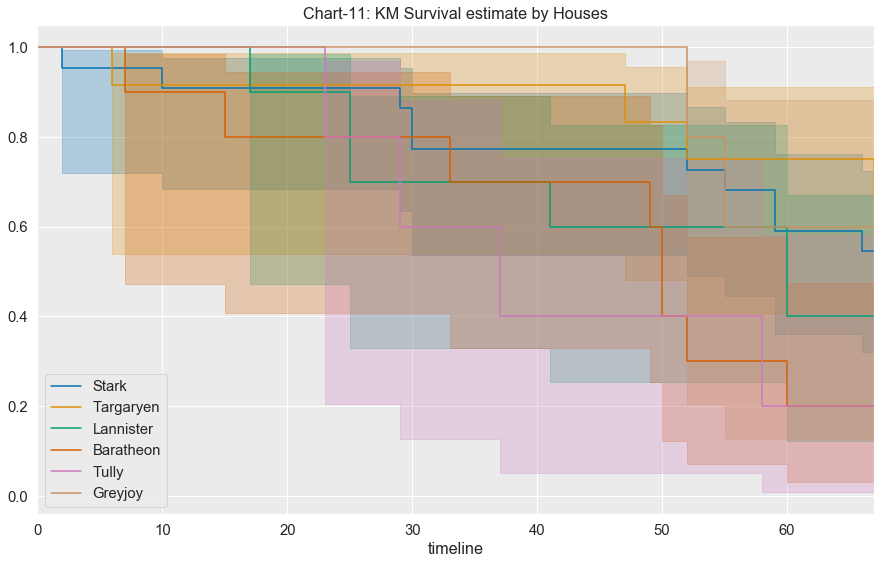

In [16]:
sns.set(palette = "colorblind", font_scale = 1.35, rc = {"figure.figsize": (15,9), "axes.facecolor": ".92"})

kmf = KaplanMeierFitter()
kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Stark'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Stark'))]['is_dead'], label='Stark')
ax = kmf.plot()

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Targaryen'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Targaryen'))]['is_dead'], label='Targaryen')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Lannister'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Lannister'))]['is_dead'], label='Lannister')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Baratheon'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Baratheon'))]['is_dead'], label='Baratheon')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Tully'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Tully'))]['is_dead'], label='Tully')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Greyjoy'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Greyjoy'))]['is_dead'], label='Greyjoy')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-11: KM Survival estimate by Houses')
ax.get_figure().savefig("chart11.png")

In [17]:
# kmf_by_hou = KaplanMeierFitter()

# duration = character_df.duration_in_episodes
# observed = character_df.is_dead
# houses = ['Stark','Targaryen','Lannister','Baratheon','Tully','Greyjoy']

# fig, axes = plt.subplots(nrows = 5, ncols = 3, sharey = True,figsize=(12,15))
 
# for hou, ax in zip(houses, axes.flatten()):
#     idx = character_df.house == hou
#     kmf_by_hou.fit(duration[idx], observed[idx])
#     kmf_by_hou.plot(ax=ax, legend=False)
# #     ax.annotate("Median = {:.0f} yrs".format(kmf_by_pos.median_), xy = (.47, .85), xycoords = "axes fraction")
#     ax.set_xlabel("")
#     ax.set_title(hou)
#     ax.set_xlim(0,25)
#     ax.set_ylim(0,1)

# fig.tight_layout()

# fig.text(0.5, -0.01, "Timeline (Years)", ha="center")
# fig.text(-0.01, 0.5, "Probability That a Player is Still Active", va="center", rotation="vertical")
# fig.suptitle("Chart-5: Survival Estimates by Houses", fontsize=20)
# fig.subplots_adjust(top=0.92)

# plt.show()

In [18]:
# df_r = character_df.set_index('character_name')

df_r = character_df.drop(['character_name'], axis=1)
df_r.house = df_r.house.fillna('')
df_r['house_Stark'] = [(1 if 'Stark' in item else 0) for item in df_r['house']]
df_r['house_Lannister'] = [(1 if 'Lannister' in item else 0) for item in df_r['house']]
df_r['house_Targaryen'] = [(1 if 'Targaryen' in item else 0) for item in df_r['house']]
df_r['house_Bolton'] = [(1 if 'Bolton' in item else 0) for item in df_r['house']]
df_r['house_Greyjoy'] = [(1 if 'Greyjoy' in item else 0) for item in df_r['house']]
df_r['house_Martell'] = [(1 if 'Martell' in item else 0) for item in df_r['house']]
df_r['house_Mormont'] = [(1 if 'Mormont' in item else 0) for item in df_r['house']]
df_r['house_Tarly'] = [(1 if 'Tarly' in item else 0) for item in df_r['house']]
df_r['house_Tully'] = [(1 if 'Tully' in item else 0) for item in df_r['house']]
df_r['house_Tyrell'] = [(1 if 'Tyrell' in item else 0) for item in df_r['house']]
df_r = df_r.drop(['house'], axis=1)

# removing per correlation matrix
df_r = df_r.drop(['s'+str(i)+'_ec' for i in range(1,8)], axis=1)
df_r = df_r.drop(['s'+str(i)+'_bc' for i in range(1,8)], axis=1)

# for i in range(1,8):
#     sp = 's' + str(i) + '_'
#     s_ec_min = df_r[sp+'ec'].min()
#     s_ec_max = df_r[sp+'ec'].max()
#     df_r[sp+'ec'] = df_r.apply(lambda x: (round((((100.00-10.00)*(x[sp+'ec']-s_ec_min))/(s_ec_max-s_ec_min)) + 10.00, 2) ), axis=1)

# /anaconda3/envs/dev2/lib/python3.7/site-packages/lifelines/utils/__init__.py:899: ConvergenceWarning: Column(s) ['s1_bc', 's1_pagerank', 's2_bc', 's2_pagerank', 's3_bc', 's3_pagerank', 's4_bc', 's4_pagerank', 's5_bc', 's5_pagerank', 's6_bc', 's6_pagerank', 's7_bc', 's7_pagerank'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
#   warnings.warn(warning_text, ConvergenceWarning)

df_dummy = pd.get_dummies(df_r, drop_first=True)

# df = character_df[['character_name']]
# df_dummy = df.merge(df_dummy, how='outer', left_index=True, right_index=True)

# df_dummy.head()

In [19]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 35 columns):
royal                               368 non-null int64
kingsguard                          368 non-null int64
s1_numOfCharactersInteractedWith    368 non-null int64
s2_numOfCharactersInteractedWith    368 non-null int64
s3_numOfCharactersInteractedWith    368 non-null int64
s4_numOfCharactersInteractedWith    368 non-null int64
s5_numOfCharactersInteractedWith    368 non-null int64
s6_numOfCharactersInteractedWith    368 non-null int64
s7_numOfCharactersInteractedWith    368 non-null int64
is_dead                             368 non-null int64
duration_in_episodes                368 non-null int64
total_screen_time                   368 non-null float64
num_of_episodes_appeared            368 non-null int64
num_of_people_killed                368 non-null int64
is_married                          368 non-null int64
have_siblings                       368 non-null int64
have_children

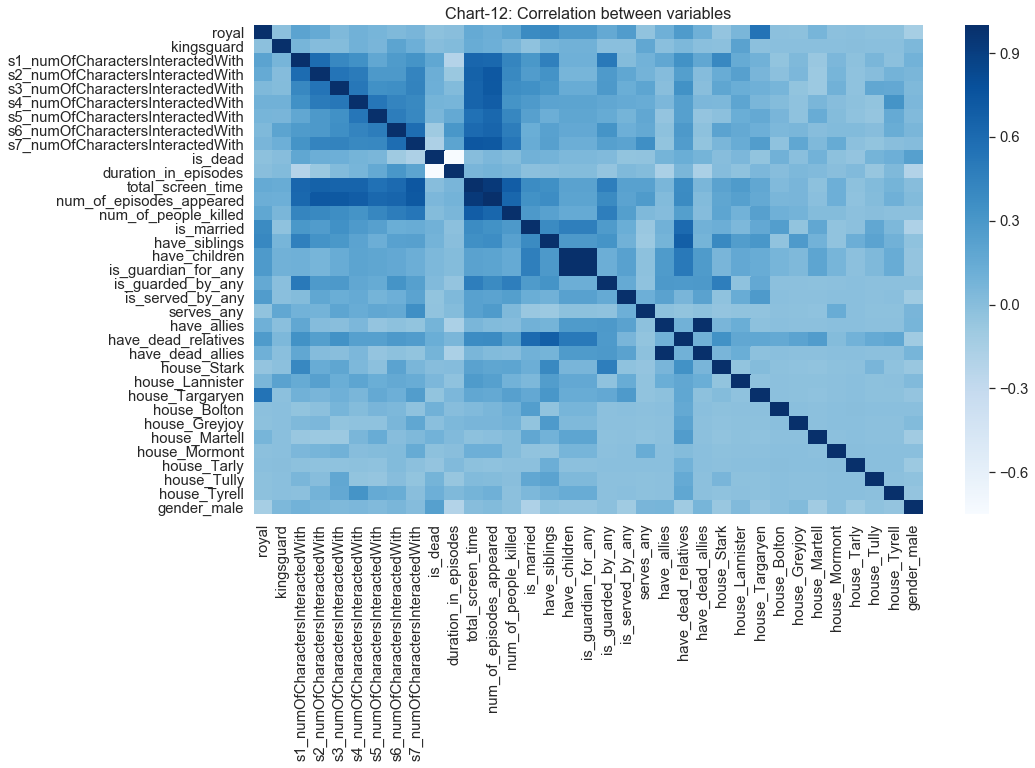

In [20]:
sns.set(palette = "colorblind", font_scale = 1.35, rc = {"figure.figsize": (15,9), "axes.facecolor": ".92"})
corr = df_dummy.corr()
# corr.style.background_gradient(cmap='coolwarm')

ax = plt.axes()
sns.heatmap(corr,ax = ax,xticklabels=corr.columns,yticklabels=corr.columns,cmap='Blues')

ax.set_title('Chart-12: Correlation between variables')
plt.show()

ax.get_figure().savefig("chart12.png")

# plot the heatmap
# sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="Blues")
# remove ec 

In [21]:
# df_dummy = df_dummy.drop(['total_screen_time','have_dead_allies','is_guardian_for_any','is_guarded_by_any','have_siblings','is_married'], axis=1)
df_dummy = df_dummy.drop(['num_of_episodes_appeared','have_allies','have_children','house_Bolton','house_Tyrell','house_Tarly'], axis=1)

# corr = df_dummy.corr()
# ax = plt.axes()
# sns.heatmap(corr,ax = ax,xticklabels=corr.columns,yticklabels=corr.columns,cmap='Blues')
# ax.set_title('Chart-13: Correlation between variables (after removing total_screen_time)')
# plt.show()
# ax.get_figure().savefig("chart13.png")

In [22]:
cph = CoxPHFitter()
cph.fit(df_dummy, 'duration_in_episodes', event_col='is_dead')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 368 observations, 203 censored>
      duration col = 'duration_in_episodes'
         event col = 'is_dead'
number of subjects = 368
  number of events = 165
    log-likelihood = -877.34
  time fit was run = 2019-04-17 06:00:43 UTC

---
                                  coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
royal                            -1.31      0.27      0.64 -2.06   0.04      4.66       -2.56       -0.06
kingsguard                        1.00      2.73      1.12  0.90   0.37      1.44       -1.19        3.19
s1_numOfCharactersInteractedWith  0.06      1.06      0.01  4.12 <0.005     14.70        0.03        0.09
s2_numOfCharactersInteractedWith  0.03      1.03      0.02  1.09   0.28      1.86       -0.02        0.07
s3_numOfCharactersInteractedWith  0.02      1.02      0.02  0.70   0.48      1.06       -0.03        0.07
s4_numOfCharactersInteractedWith  0.01      1.01      0.02  0.54   0.59      0.77       -0.0

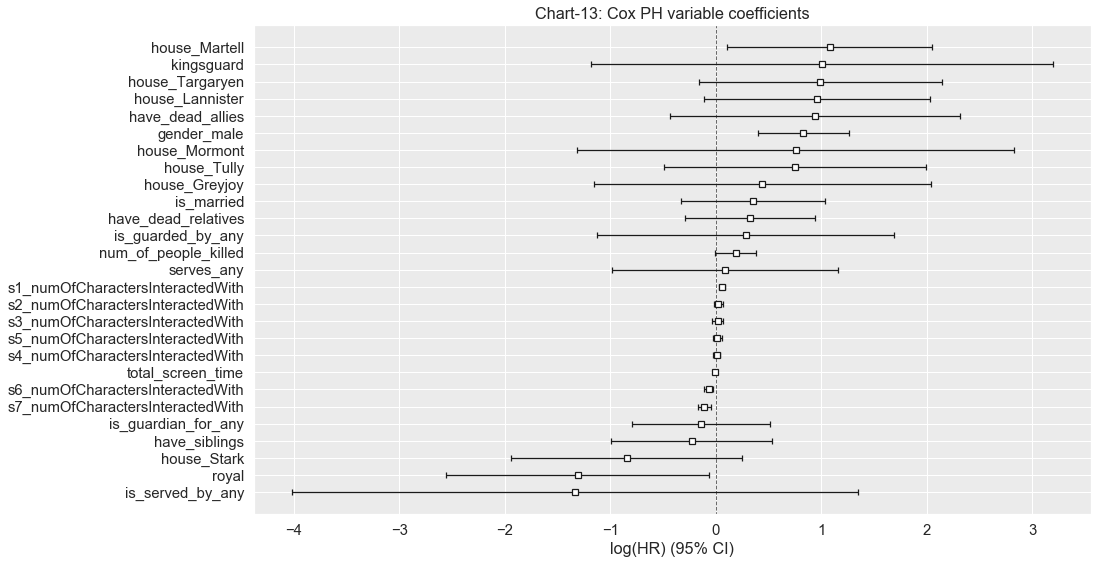

In [23]:
ax = cph.plot()
ax.set_title('Chart-13: Cox PH variable coefficients')
ax.get_figure().savefig("chart13.png")

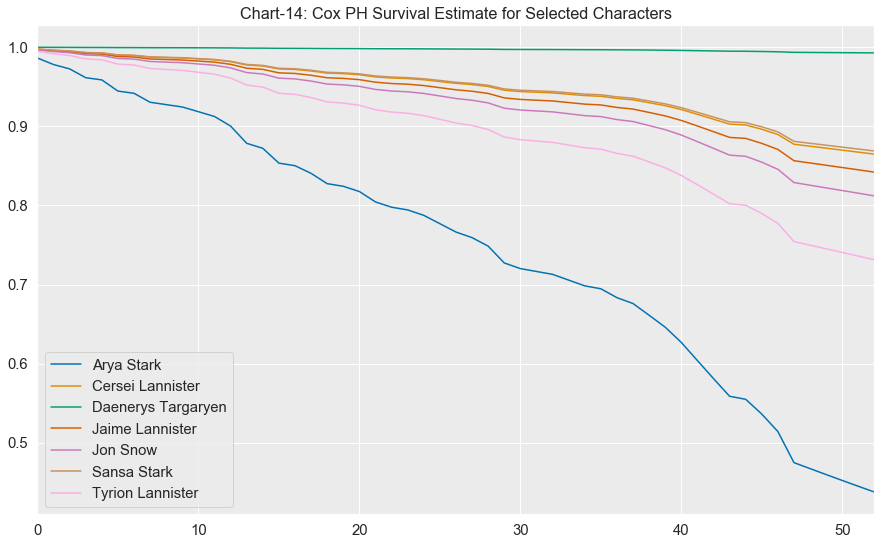

In [24]:
#tr_rows = df_dummy.iloc[10:20, ]
#tr_rows = df_dummy.iloc[character_df.index[(character_df.house.notnull()) & (character_df.house.str.contains('Stark'))].tolist(), ]

#df_dummy = df_dummy.set_index('character_name')

df2 = character_df[['character_name']]
df2 = df2.merge(df_dummy, how='outer', left_index=True, right_index=True)
tr_rows = df2[df2.character_name.isin(['Tyrion Lannister','Arya Stark','Cersei Lannister','Jaime Lannister','Jon Snow','Sansa Stark','Daenerys Targaryen'])]

tr_rows = tr_rows.set_index('character_name')
ax = cph.predict_survival_function(tr_rows).plot(use_index=False)
ax.set_title('Chart-14: Cox PH Survival Estimate for Selected Characters')
ax.get_figure().savefig("chart14.png")

# cph.predict_survival_function(tr_rows, [50,67])#.plot(use_index=False)

In [25]:
cph.predict_cumulative_hazard(tr_rows,[67])

Arya Stark            0.825995
Cersei Lannister      0.145188
Daenerys Targaryen    0.007223
Jaime Lannister       0.171814
Jon Snow              0.208163
Sansa Stark           0.140605
Tyrion Lannister      0.312760
Name: 67, dtype: float64

In [26]:
cph.predict_survival_function(tr_rows, [67])#.plot(use_index=False)

Arya Stark            0.437799
Cersei Lannister      0.864859
Daenerys Targaryen    0.992803
Jaime Lannister       0.842136
Jon Snow              0.812075
Sansa Stark           0.868832
Tyrion Lannister      0.731425
Name: 67, dtype: float64